<a href="https://colab.research.google.com/github/db030220/Plogging/blob/main/trashmodel%EC%99%84%EC%84%B1%EB%B3%B84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#1차 인공지능
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
#이미지 가져오기
caltech_dir = "/content/drive/MyDrive/2023finalproject/img3/"
categories = ["person","hand","trash"]
nb_classes = len(categories)

image_w=64
image_h=64
pixels = image_h* image_w*3
X=[]
y=[]

for idx, cat in enumerate(categories):
  label=[0 for i in range(nb_classes)]
  label[idx] =1
  image_dir=caltech_dir +"/"+cat
  files=glob.glob(image_dir+"/*.jpg")
  print(cat, " 파일길이 : ", len(files))
  for i, f in enumerate(files):
    img=Image.open(f)
    img=img.convert("RGB")
    img=img.resize((image_w,image_h))
    data=np.asarray(img)

    X.append(data)
    y.append(label)

    if i%700==0:
      print(cat," : ",f)

X=np.array(X)
y=np.array(y)

X_train,X_test,y_train,y_test=train_test_split(X,y)
xy=(X_train, X_test,y_train,y_test)
np.save("/content/drive/MyDrive/2023finalproject/data.npy",xy)

print("ok",len(y))

person  파일길이 :  1004
person  :  /content/drive/MyDrive/2023finalproject/img3//person/사람5.jpg
person  :  /content/drive/MyDrive/2023finalproject/img3//person/puls_2_0_3767.jpg
hand  파일길이 :  987
hand  :  /content/drive/MyDrive/2023finalproject/img3//hand/손있는봉투2.jpg
hand  :  /content/drive/MyDrive/2023finalproject/img3//hand/puls_2_0_180.jpg
trash  파일길이 :  1003
trash  :  /content/drive/MyDrive/2023finalproject/img3//trash/쓰레기봉투만5.jpg
trash  :  /content/drive/MyDrive/2023finalproject/img3//trash/쓰레기봉투만603.jpg
ok 2994


/usr/local/lib/python3.9/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.backend import set_session as K

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
#버전이상으로 변경
X_train, X_test, y_train, y_test = np.load('/content/drive/MyDrive/2023finalproject/data.npy',allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
print(X_test.shape)
print(X_test.shape[0])

(2245, 64, 64, 3)
2245
(749, 64, 64, 3)
749


In [ ]:
categories = ["person","hand","trash"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [ ]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    #chatgpt에 기반한 추가 사항
    model.add(Conv2D(128, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
   # adam=tf.keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)
    
    

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 16, 16, 64)       

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])


Epoch 1/25
71/71 [==============================] - ETA: 0s - loss: 1.1625 - accuracy: 0.3715
Epoch 1: val_loss improved from inf to 1.04784, saving model to ./model/multi_img_classification.model


71/71 [==============================] - 34s 467ms/step - loss: 1.1625 - accuracy: 0.3715 - val_loss: 1.0478 - val_accuracy: 0.5661
Epoch 2/25
71/71 [==============================] - ETA: 0s - loss: 0.9393 - accuracy: 0.5630
Epoch 2: val_loss improved from 1.04784 to 0.90307, saving model to ./model/multi_img_classification.model


71/71 [==============================] - 43s 605ms/step - loss: 0.9393 - accuracy: 0.5630 - val_loss: 0.9031 - val_accuracy: 0.5728
Epoch 3/25
71/71 [==============================] - ETA: 0s - loss: 0.8176 - accuracy: 0.6419
Epoch 3: val_loss improved from 0.90307 to 0.79430, saving model to ./model/multi_img_classification.model


71/71 [==============================] - 46s 643ms/step - loss: 0.8176 - accuracy: 0.6419 - val_loss: 0.7943 - val_accuracy: 0.6689
Epoch 4/25
71/71 [==============================] - ETA: 0s - loss: 0.7617 - accuracy: 0.6731
Epoch 4: val_loss improved from 0.79430 to 0.78835, saving model to ./model/multi_img_classification.model


71/71 [==============================] - 32s 449ms/step - loss: 0.7617 - accuracy: 0.6731 - val_loss: 0.7883 - val_accuracy: 0.6636
Epoch 5/25
71/71 [==============================] - ETA: 0s - loss: 0.7216 - accuracy: 0.6984
Epoch 5: val_loss improved from 0.78835 to 0.69521, saving model to ./model/multi_img_classification.model


71/71 [==============================] - 34s 476ms/step - loss: 0.7216 - accuracy: 0.6984 - val_loss: 0.6952 - val_accuracy: 0.7089
Epoch 6/25
71/71 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.7149
Epoch 6: val_loss did not improve from 0.69521
71/71 [==============================] - 32s 454ms/step - loss: 0.6724 - accuracy: 0.7149 - val_loss: 0.7012 - val_accuracy: 0.7049
Epoch 7/25
71/71 [==============================] - ETA: 0s - loss: 0.6272 - accuracy: 0.7359
Epoch 7: val_loss improved from 0.69521 to 0.61964, saving model to ./model/multi_img_classification.model


71/71 [==============================] - 32s 454ms/step - loss: 0.6272 - accuracy: 0.7359 - val_loss: 0.6196 - val_accuracy: 0.7610
Epoch 8/25
71/71 [==============================] - ETA: 0s - loss: 0.5774 - accuracy: 0.7635
Epoch 8: val_loss did not improve from 0.61964
71/71 [==============================] - 32s 446ms/step - loss: 0.5774 - accuracy: 0.7635 - val_loss: 0.6201 - val_accuracy: 0.7583
Epoch 9/25
71/71 [==============================] - ETA: 0s - loss: 0.5250 - accuracy: 0.7840
Epoch 9: val_loss improved from 0.61964 to 0.58446, saving model to ./model/multi_img_classification.model


71/71 [==============================] - 32s 449ms/step - loss: 0.5250 - accuracy: 0.7840 - val_loss: 0.5845 - val_accuracy: 0.7543
Epoch 10/25
71/71 [==============================] - ETA: 0s - loss: 0.4847 - accuracy: 0.8036
Epoch 10: val_loss improved from 0.58446 to 0.57089, saving model to ./model/multi_img_classification.model


71/71 [==============================] - 33s 463ms/step - loss: 0.4847 - accuracy: 0.8036 - val_loss: 0.5709 - val_accuracy: 0.7770
Epoch 11/25
71/71 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.8067
Epoch 11: val_loss improved from 0.57089 to 0.57037, saving model to ./model/multi_img_classification.model


71/71 [==============================] - 33s 473ms/step - loss: 0.4640 - accuracy: 0.8067 - val_loss: 0.5704 - val_accuracy: 0.7610
Epoch 12/25
71/71 [==============================] - ETA: 0s - loss: 0.4093 - accuracy: 0.8334
Epoch 12: val_loss did not improve from 0.57037
71/71 [==============================] - 31s 431ms/step - loss: 0.4093 - accuracy: 0.8334 - val_loss: 0.6126 - val_accuracy: 0.7610
Epoch 13/25
71/71 [==============================] - ETA: 0s - loss: 0.3493 - accuracy: 0.8597
Epoch 13: val_loss improved from 0.57037 to 0.53126, saving model to ./model/multi_img_classification.model


71/71 [==============================] - 33s 459ms/step - loss: 0.3493 - accuracy: 0.8597 - val_loss: 0.5313 - val_accuracy: 0.7984
Epoch 14/25
71/71 [==============================] - ETA: 0s - loss: 0.3294 - accuracy: 0.8682
Epoch 14: val_loss did not improve from 0.53126
71/71 [==============================] - 30s 431ms/step - loss: 0.3294 - accuracy: 0.8682 - val_loss: 0.5405 - val_accuracy: 0.8064
Epoch 15/25
71/71 [==============================] - ETA: 0s - loss: 0.3254 - accuracy: 0.8677
Epoch 15: val_loss did not improve from 0.53126
71/71 [==============================] - 30s 430ms/step - loss: 0.3254 - accuracy: 0.8677 - val_loss: 0.5739 - val_accuracy: 0.7997
Epoch 16/25
71/71 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.9109
Epoch 16: val_loss did not improve from 0.53126
71/71 [==============================] - 31s 434ms/step - loss: 0.2485 - accuracy: 0.9109 - val_loss: 0.5471 - val_accuracy: 0.7917
Epoch 17/25
71/71 [========================

In [ ]:
#1차 인공지능정확도
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

24/24 [==============================] - 2s 82ms/step - loss: 0.6322 - accuracy: 0.8051
정확도 : 0.8051


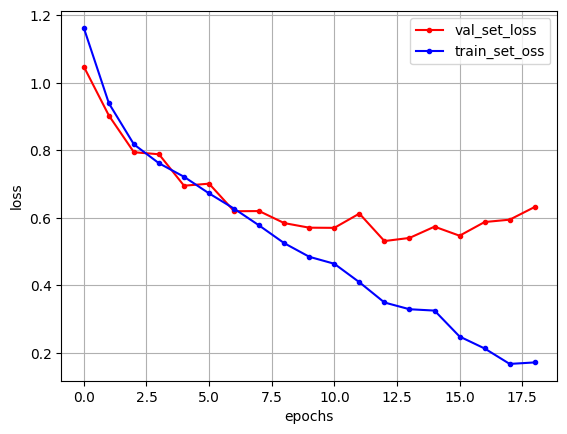

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [ ]:
!pip install pytorch
!pip install matplotlib
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/yolov5/runs/detect/exp/test2.jpg')
cv2_imshow(img)

In [ ]:
!pip install torch torchvision numpy matplotlib Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade google-cloud-vision

In [ ]:
!pip install google-cloud-vision


In [ ]:
#3차 인공지능
#구글 비전 api에서 따로 연결 해줘야 가능

import re

# 추출된 텍스트를 숫자로 필터링하는 함수
def filter_numbers(text):
    numbers = re.findall(r'\d+', text)  # 정규식을 사용하여 숫자 추출
    return numbers
     

In [ ]:
from google.cloud import vision

# 이미지 파일 경로 설정
image_path = '/content/drive/MyDrive/2023finalproject/trash334.png'

# Vision API 클라이언트 인스턴스 생성
client = vision.ImageAnnotatorClient()

# 이미지 읽어오기
with open(image_path, 'rb') as image_file:
    content = image_file.read()

# Image 객체 생성 및 이미지 속성 설정
image = vision.Image(content=content)

from google.cloud import vision
from google.oauth2 import service_account

# 인증 정보(JSON 파일)의 경로 설정
credentials = service_account.Credentials.from_service_account_file('....')


In [ ]:
# Vision API 클라이언트 인스턴스 생성
client = vision.ImageAnnotatorClient(credentials=credentials)


# 이미지에 대한 텍스트 감지 요청
response = client.text_detection(image=image)
texts = response.text_annotations

extracted_numbers = []
if texts:
    for text in texts:
        numbers = filter_numbers(text.description)
        extracted_numbers.extend(numbers)

def process_extracted_numbers(extracted_numbers):
    if extracted_numbers:
        print('Extracted Numbers:')
        for number in extracted_numbers:
            return str(number)
    else:
        print('No text found in the image.')

# 함수 호출
textfromnum=process_extracted_numbers(extracted_numbers)

In [ ]:
def convert_to_list(extracted_numbers):
    result = []
    for number in extracted_numbers:
        result.extend(list(str(number)))
    return result


In [ ]:
numresult=convert_to_list(textfromnum)
print(numresult)

In [ ]:
def remove_last_value(lst):
    if lst:
        lst = lst[:-1]
    return lst

updated_list = remove_last_value(numresult)
print(updated_list)

In [ ]:
def convert_to_string(extracted_numbers):
    result = ""
    for number in extracted_numbers:
        result += str(number)
    return result

string_num = convert_to_string(updated_list)
print(int(string_num))